# Tracker Float analysis
second notebook to keep track of per layer.

In [66]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt

In [67]:
file_path = "/Users/swasti/Library/CloudStorage/Box-Box/ComPair/balloon_flight/CPU_data/230827/tracker/L3_selected/float_5files_withgaps/TRK_float_combined.L3.h5"

In [68]:
file = h5py.File(file_path,'r')

In [69]:
file['tracker'].keys()

<KeysViewHDF5 ['energy', 'event_id', 'event_time', 'pulse_height']>

In [70]:
#==== Defining some global variables ====
NLAYERS = 10
NLAYERS_FLAG = False            # flag to define nlayers from commanline, default calculates Nlayers.
NRG_PER = 60 # percentage to check energy
NEIGHBOR_LENGTH = 1

XPOS_TBL_new = np.zeros((192))
YPOS_TBL_new = np.zeros((192))
ZPOS_TBL_new = np.zeros((10))

def define_XYZ_table_new():
    """Defining XYZ table via function. Need to define here and use global for the ability of the script to modify with different NLAYERS value.
    """
        
    global NLAYERS
    global XPOS_TBL_new
    global YPOS_TBL_new
    global ZPOS_TBL_new

    TKR_STRIP_PITCH     = 0.051                             # [cm] 510 microns
    TKR_WIDTH           = 192 * TKR_STRIP_PITCH             # [cm] 192 strips of constant pitch
    TKR_EDGE            = TKR_WIDTH/2.0                     # DSSD is centered at 0, thus the edges are equivalent to half of the width
    TKR_STRIP_CENTROID  = TKR_EDGE - (TKR_STRIP_PITCH)/2.0  # Gives the center of strip 191
    TRK_LAYER_THICKNESS = 0.05
    TKR_LAYER_SPACING   = 1.9                               # [cm] z spacing between layers
    TKR_TOP_LAYER       = (TRK_LAYER_THICKNESS/2.0) + (NLAYERS - 1) * TKR_LAYER_SPACING

    for detector_number in range(NLAYERS):
        ZPOS_TBL_new[detector_number] = float(-detector_number * TKR_LAYER_SPACING + TKR_TOP_LAYER)

    for strip_number in range(192):
        XPOS_TBL_new[strip_number] = float(-strip_number * TKR_STRIP_PITCH + TKR_STRIP_CENTROID)
        YPOS_TBL_new[strip_number] = float(strip_number * TKR_STRIP_PITCH - TKR_STRIP_CENTROID)

define_XYZ_table_new()

In [71]:
def get_trk_nrg(trk_nrg, evt_id):
    """Get tracker energy in (n_evt, energy) format.
    
    Parameters
    ----------
        trk_nrg : dataset
            trk energy => f_trk['Events/TKR/Energy'][...]
        evt_id : dataset
            event id dataset => evt_id = f_trk['Events/TKR/EventID'][...] 
    Returns
    -------
        Energy array in an (nevents, no.hits) shape. nohits here defined by max hit per event id
    """
    nrg_id = trk_nrg[:,0] # select the tracker energy id
    unique_nrgid, counts = np.unique(nrg_id, return_counts=True) # get unique eventid and the no. of counts
    new_energy_ar = np.zeros(shape=(evt_id.shape[0],max(counts))) # evt_id = unique event id

    print(unique_nrgid.shape[0])
    for u_id in range(unique_nrgid.shape[0]):
        print(u_id) if u_id%10000 == 0 else None
        # if u_id==50000:
        #     break
        tid = unique_nrgid[u_id]                # unique id.
        t_loc = np.where(nrg_id ==tid)          # find locations for the ids
        t_loc1 = np.where(tid == evt_id)        # find where the ids are in event ids.
        t_nrg= trk_nrg[t_loc[0],4]            # get the energies.
    
        for j in range(len((t_loc[0]))):
            new_energy_ar[t_loc1[0],j] = t_nrg[j]

    return new_energy_ar

In [72]:
all_array1 = file['tracker/energy'][...]
all_array1.shape

(1571201, 6)

In [73]:
# Filter condition
filter_condition = (all_array1[..., 5] == 1) | (all_array1[..., 5] == 2)

# Create new_array using boolean indexing
all_array = all_array1[filter_condition]
all_array.shape

(1464429, 6)

In [74]:
ZPOS_TBL_new

array([17.125, 15.225, 13.325, 11.425,  9.525,  7.625,  5.725,  3.825,
        1.925,  0.025])

In [91]:
layer = 1
zpos_fil = round(ZPOS_TBL_new[layer],3)
print(zpos_fil)
lay_array = all_array[all_array[...,3] == zpos_fil]
nrg_arr = np.array(lay_array[:,4])
evt_id = np.array(lay_array[:,0])
new_nrgarr=get_trk_nrg(lay_array, evt_id)

15.225
119808
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [92]:
new_nrgarr.shape

(128594, 4)

In [93]:
evt_nrg= np.sum(new_nrgarr, axis=1)
evt_nrg.shape, evt_nrg

((128594,),
 array([176.8212 , 176.8212 , 462.71355, ..., 151.5453 , 260.17145,
        260.17145]))

In [94]:
plt.hist(evt_nrg), bins=500, range=[0,5000], histtype="step")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.grid(True,alpha=0.3)
plt.title(f" TRK Counts vs Nrg (Per Hit) @ Float Layer:{layer}")

SyntaxError: unmatched ')' (2520252060.py, line 1)

In [12]:
new_nrgarr.shape

(1464429, 19)

In [14]:
new_nrgarr[0]

array([110.643 , 125.9307, 165.3595,  66.1782,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ])

In [13]:
evt_nrg= np.sum(new_nrgarr, axis=1)
evt_nrg.shape

(1464429,)

In [16]:
plt.scatter(evt_nrg)

TypeError: scatter() missing 1 required positional argument: 'y'

Text(0.5, 1.0, 'TRK Counts vs Nrg (Per Hit) @ Float (9L,L3)')

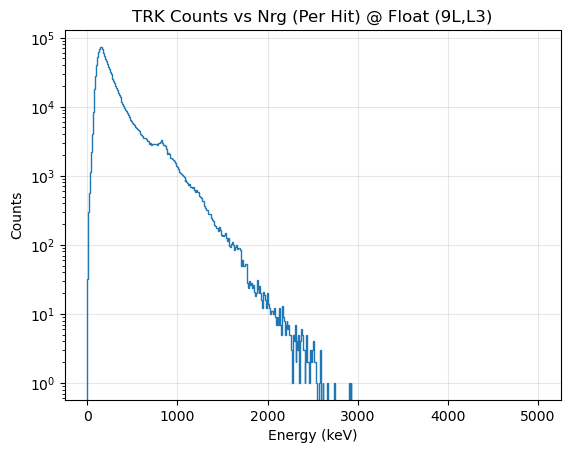

In [63]:
plt.hist(nrg_arr, bins=500, range=[0,5000], histtype="step")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.grid(True,alpha=0.3)
plt.title("TRK Counts vs Nrg (Per Hit) @ Float (9L,L3)")

Text(0.5, 1.0, 'TRK Counts vs Nrg (Per Hit) @ Float (9L,L3)')

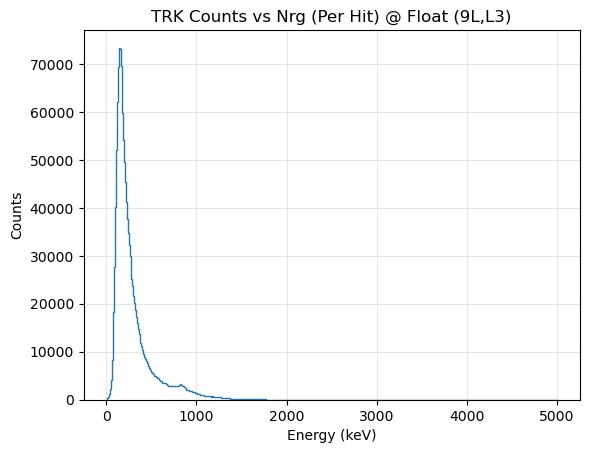

In [62]:
plt.hist(nrg_arr, bins=500, range=[0,5000], histtype="step")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.grid(True,alpha=0.3)
plt.title("TRK Counts vs Nrg (Per Hit) @ Float (9L,L3)")

# ALong EVT

In [52]:
evt_nrg= np.sum(new_nrgarr, axis=1)
evt_nrg.shape

(1464429,)

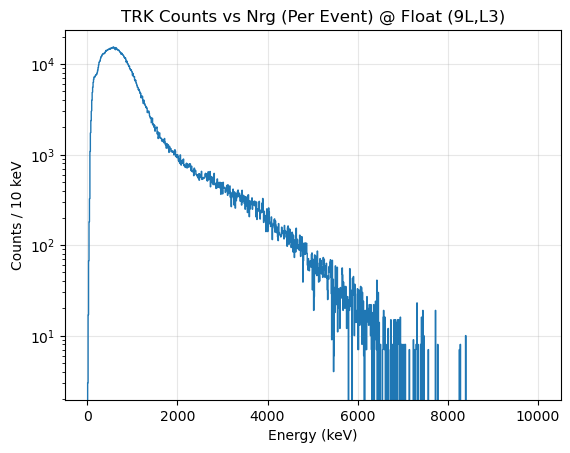

In [72]:
plt.hist(evt_nrg, bins=1000, range=[0,10000], histtype="step")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / 10 keV")
plt.title("TRK Counts vs Nrg (Per Event) @ Float (9L,L3)")
plt.grid(True,alpha=0.3)
plt.yscale("log")

(0.0, 100.0)

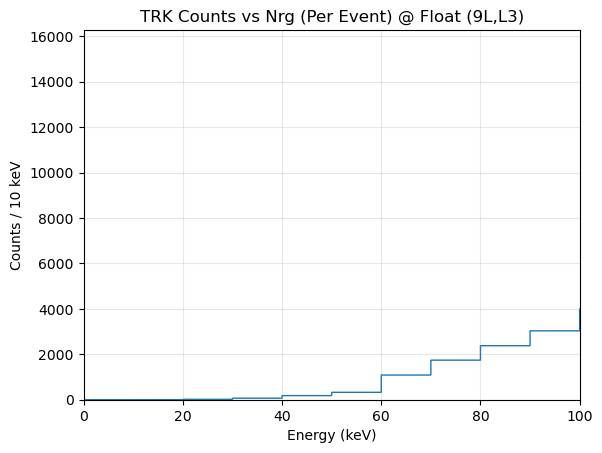

In [74]:
plt.hist(evt_nrg, bins=1000, range=[0,10000], histtype="step")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / 10 keV")
plt.title("TRK Counts vs Nrg (Per Event) @ Float (9L,L3)")
plt.grid(True,alpha=0.3)
plt.xlim(0,100)

In [ ]:
=2.496 * e